## 1. Definição do Problema e Objetivos

O problema central deste projeto é a dificuldade que usuários de plataformas como a Coursera enfrentam para encontrar cursos relevantes, dada a vasta quantidade de opções. A sobrecarga de informações pode levar a escolhas inadequadas, resultando em baixo engajamento e altas taxas de abandono.

Este notebook foca na implementação da **Filtragem Baseada em Conteúdo**. Os objetivos específicos desta implementação são:
- Analisar o comportamento dos usuários e as avaliações dos cursos. 
- Implementar a filtragem baseada em conteúdo, que se baseia nas características (habilidades) dos cursos que o usuário avaliou positivamente.
- Gerar perfis de interesse para cada usuário com base nos atributos dos cursos
- Calcular a similaridade de cosseno entre o perfil do usuário e o catálogo de cursos para encontrar os mais aderentes
-  Avaliar as recomendações geradas de forma qualitativa e quantitativa.

## 2. Definição das Bibliotecas Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

## 3. Definição do Dataset

In [2]:
df_course = pd.read_csv('coursera_course_dataset_v3.csv', index_col=0).reset_index(drop=True)
df_course = df_course[['Title','Skills']]
df_course.head()

,Title,Skills
0,Google Cybersecurity,"Network Security, Python Programming, Linux, ..."
1,Google Data Analytics,"Data Analysis, R Programming, SQL, Business C..."
2,Google Project Management:,"Project Management, Strategy and Operations, ..."
3,IBM Data Science,"Python Programming, Data Science, Machine Lea..."
4,Google Digital Marketing & E-commerce,"Digital Marketing, Marketing, Marketing Manag..."


In [3]:
review = pd.read_csv('Coursera_reviews.csv')
review.head()

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [4]:
course = pd.read_csv('Coursera_courses.csv')
course.head()

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being
3,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals
4,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,google-cbrs-cpi-training


## 4. Análise Exploratória e Tratamento de Dados

O primeiro passo do tratamento é unificar os dataframes de cursos (`course`) e de avaliações (`review`), criando um dataframe único (`review_df`) que conecta os usuários às informações dos cursos que eles avaliaram.

In [5]:
review_df = pd.merge(course, review, on='course_id', how='left')
review_df.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1.0
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,"Nov 09, 2015",1.0
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,"Apr 15, 2019",1.0
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,"Sep 25, 2015",1.0
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,"Dec 12, 2015",1.0


A seguir, realizamos a limpeza e preparação dos dados. Isso inclui:
- Remover o prefixo "By " da coluna de avaliadores para padronizar os nomes.
- Criar um `reviewer_id` numérico único para cada usuário, o que otimiza o processamento.
- Remover colunas que não serão utilizadas no modelo de conteúdo (como instituição, URL, e o texto das avaliações) para simplificar o conjunto de dados.

In [6]:
review_df['reviewers'] = review_df['reviewers'].str.replace('By ', '')
reviewer_ids = {reviewer: idx for idx, reviewer in enumerate(review_df['reviewers'].unique())}
review_df['reviewer_id'] = review_df['reviewers'].map(reviewer_ids)
review_df.dropna(subset=['reviewers'], inplace=True, axis=0)
review_df.drop(columns=['institution','course_url','course_id','reviews','date_reviews'], inplace=True)
review_df.head()

,name,reviewers,rating,reviewer_id
0,Machine Learning,Deleted A,1.0,0
1,Machine Learning,Bruno C,1.0,1
2,Machine Learning,Fadi,1.0,2
3,Machine Learning,Mathew L,1.0,3
4,Machine Learning,Rui C,1.0,4


In [7]:
print("Quantidade de avaliadores únicos: ", len(review_df['reviewers'].unique()))
print("Quantidade de cursos distintos: ", len(review_df['name'].unique()))

Quantidade de avaliadores únicos:  287808
Quantidade de cursos distintos:  603


Após a mesclagem e limpeza, uma análise quantitativa simples foi realizada para entender a escala do problema. O código a seguir revela a existência de **287.808 avaliadores únicos** e **603 cursos distintos**. Essa etapa foi fundamental para compreender a dimensionalidade da matriz de interação usuário-item (usuários x cursos) e para planejar as fases subsequentes de pré-processamento.

## 5. Definição da Técnica (Vetorização TF-IDF)

A técnica escolhida para este projeto é a **Filtragem Baseada em Conteúdo (Content-Based Filtering)**. Esta abordagem recomenda itens com base em suas características (o "conteúdo") e na relação destes com as preferências do usuário. Neste caso, o "conteúdo" é definido pelas **habilidades (Skills)** de cada curso.

O primeiro passo é transformar a coluna `Skills` (que contém texto) em uma matriz de vetores numéricos, utilizando a técnica **TF-IDF (Term Frequency-Inverse Document Frequency)** com o `TfidfVectorizer`. Isso resulta em um perfil vetorial para cada curso, onde cada habilidade se torna uma característica com um peso correspondente à sua importância.

In [8]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(', '))

skills_matrix = vectorizer.fit_transform(df_course['Skills'])

skills_df = pd.DataFrame(skills_matrix.toarray(), columns=vectorizer.get_feature_names_out())

df_course_profile = pd.concat([df_course.drop(columns=['Skills']), skills_df], axis=1)
df_course_profile

C:\Users\Bruno\AppData\Roaming\Python\Python313\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,Title,accounting,agile software development,algebra,algorithms,amazon web services,apache,application development,applied machine learning,arcgis,...,user experience,user experience design,user research,visual design,visualization (computer graphics),warehouse management,web design,web development,web development tools,writing
0,Google Cybersecurity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,Google Data Analytics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,Google Project Management:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,IBM Data Science,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.203499
4,Google Digital Marketing & E-commerce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.236076,0.206945,0.246033,0.218389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,Google Workspace Security,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
619,Cybersecurity for Tech Professionals,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
620,Cybersecurity in the Cloud,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
621,Applied Cryptography,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


## 6. Realização do Treinamento do Modelo

In [9]:
merged_df = pd.merge(df_course_profile, review_df, left_on="Title",right_on='name', how='left')
merged_df.head()

,Title,accounting,agile software development,algebra,algorithms,amazon web services,apache,application development,applied machine learning,arcgis,...,visualization (computer graphics),warehouse management,web design,web development,web development tools,writing,name,reviewers,rating,reviewer_id
0,Google Cybersecurity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
1,Google Data Analytics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2,Google Project Management:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
3,IBM Data Science,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.203499,NaN,NaN,NaN,NaN
4,Google Digital Marketing & E-commerce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.236076,0.206945,0.246033,0.218389,NaN,NaN,NaN,NaN


Para construir a matriz de utilidade (usuário-item), precisamos conectar as avaliações (`review_df`) com os perfis de habilidades dos cursos (`df_course_profile`) que criamos na etapa anterior.

In [10]:
unique_titles = merged_df['Title'].unique()
pivot_df = merged_df.pivot_table(index='reviewer_id', columns='Title', values='rating', aggfunc='mean', fill_value=0)
pivot_df = pivot_df.reindex(columns=unique_titles, fill_value=0)
pivot_df.reset_index(inplace=True, drop=True)
pivot_df

Title,Google Cybersecurity,Google Data Analytics,Google Project Management:,IBM Data Science,Google Digital Marketing & E-commerce,IBM Data Analyst,Google IT Support,Machine Learning,Google UX Design,IBM DevOps and Software Engineering,...,Security Awareness Training,Security Governance & Compliance,Cybersecurity and Mobility,Security Operations,Security Principles,Google Workspace Security,Cybersecurity for Tech Professionals,Cybersecurity in the Cloud,Applied Cryptography,Python for Active Defense
0,0,0,0,0,0,0,0,4.556818,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,3.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110787,0,0,0,0,0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
110788,0,0,0,0,0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
110789,0,0,0,0,0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
110790,0,0,0,0,0,0,0,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6.1 Etapa Intermediária: Exportação de Cursos Realizados

Como uma etapa auxiliar, o bloco de código a seguir identifica todos os cursos que cada usuário já avaliou (ou seja, "realizou") e salva essa relação em um novo arquivo CSV (`coursera_user_and_course.csv`). Isso é feito "derretendo" (melt) a matriz pivô para transformar o formato largo (usuários x cursos) em um formato longo (usuário, curso), facilitando outras análises.

In [11]:
user_courses_df = pd.DataFrame(index=pivot_df.index)

course_dfs = []

for course in pivot_df.columns:
    course_df = pd.DataFrame({course: pivot_df[course].apply(lambda x: 1 if x > 0 else 0)})
    course_dfs.append(course_df)

user_courses_df = pd.concat(course_dfs, axis=1)
user_courses_df.reset_index(inplace=True)

C:\Users\Bruno\AppData\Local\Temp\ipykernel_17652\4136271089.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  user_courses_df.reset_index(inplace=True)


In [12]:
melted_df = user_courses_df.melt(id_vars='index', var_name='course', value_name='taken')

taken_courses_df = melted_df[melted_df['taken'] == 1]

taken_courses_df.drop(columns='taken', inplace=True)
taken_courses_df.rename(columns={'index':'user_id'}, inplace=True)

taken_courses_df.to_csv('coursera_user_and_course.csv', index=None)

taken_courses_df

C:\Users\Bruno\AppData\Local\Temp\ipykernel_17652\3167328005.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taken_courses_df.drop(columns='taken', inplace=True)
C:\Users\Bruno\AppData\Local\Temp\ipykernel_17652\3167328005.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taken_courses_df.rename(columns={'index':'user_id'}, inplace=True)


,user_id,course
775544,0,Machine Learning
775545,1,Machine Learning
775546,2,Machine Learning
775547,3,Machine Learning
775548,4,Machine Learning
...,...,...
67788745,94833,Cryptography I
67788746,94834,Cryptography I
67788747,94835,Cryptography I
67788748,94836,Cryptography I


### 6.2 Realização do Treinamento (Criação dos Perfis de Usuário)

O "treinamento" do modelo, neste contexto, consiste na construção dos perfis de usuário. O perfil de cada usuário é gerado multiplicando-se a matriz de avaliações (a tabela pivô `pivot_df`) pela matriz de características dos cursos (criada com TF-IDF). O resultado (`user_profile_df`) é um vetor para cada usuário que reflete sua afinidade ponderada por cada habilidade, com base nos cursos que ele avaliou positivamente.

In [13]:
course_vector_df = df_course_profile.drop(columns=['Title'])
course_vector = course_vector_df.values
user_vector = pivot_df.values
print(user_vector.shape)
print(course_vector.shape)

(110792, 623)
(623, 455)


In [14]:
user_profile = np.matmul(user_vector, course_vector)
print(user_profile.shape)

(110792, 455)


In [15]:
skill_names = course_vector_df.columns
user_profile_df = pd.DataFrame(user_profile, columns=skill_names)
user_profile_df

,accounting,agile software development,algebra,algorithms,amazon web services,apache,application development,applied machine learning,arcgis,artificial neural networks,...,user experience,user experience design,user research,visual design,visualization (computer graphics),warehouse management,web design,web development,web development tools,writing
0,1.916249,1.508786,0.0,7.568759,0.0,0.0,0.0,0.0,0.0,1.701438,...,0.0,1.611441,0.0,0.0,2.729244,1.485871,0.0,1.759242,0.0,4.469327
1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.932141,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110787,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,1.279762,0.000000,0.0,0.000000,0.0,0.000000
110788,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,1.279762,0.000000,0.0,0.000000,0.0,0.000000
110789,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,1.279762,0.000000,0.0,0.000000,0.0,0.000000
110790,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,1.279762,0.000000,0.0,0.000000,0.0,0.000000


Finalmente, salvamos os perfis de usuário gerados em um arquivo CSV (`coursera_user_profile.csv`) para uso futuro.

In [16]:
user_profile_df.to_csv("coursera_user_profile.csv")

## 7. Avaliação de Desempenho (Geração de Recomendações)

As recomendações acima podem incluir cursos que o usuário já avaliou. Para sugestões mais úteis, devemos filtrar esses itens. O código a seguir melhora a lógica: ele primeiro identifica os cursos que o usuário já avaliou (onde a nota é > 0) na matriz pivô e, em seguida, itera sobre os cursos com maior similaridade, exibindo apenas os 5 melhores que o usuário **ainda não** avaliou.

In [17]:
similarities = cosine_similarity(user_profile_df, course_vector_df)
similarities.shape

(110792, 623)

In [18]:
course_df = df_course_profile.set_index('Title')
random_users = np.random.choice(len(user_profile_df), 10, replace=False)

top_indices = np.argsort(similarities, axis=1)[:, ::-1]

N = 5  
for user_index in random_users:
    print(f"Melhores cursos para o usuário: {user_index + 1}:")
    for course_index in top_indices[user_index][:N]:
        title = course_df.index[course_index] 
        similarity_score = similarities[user_index, course_index]  
        print(f"Curso: {title}, Similaridade de Cosseno: {similarity_score:.2f}")
    print()

Melhores cursos para o usuário: 75851:
Curso: Learning How to Learn: Powerful mental tools to help you master tough subjects, Similaridade de Cosseno: 1.00
Curso: How Entrepreneurs in Emerging Markets can master the Blockchain Technology, Similaridade de Cosseno: 0.24
Curso: Uncommon Sense Teaching, Similaridade de Cosseno: 0.22
Curso: Building Fintech Startups in Emerging Markets, Similaridade de Cosseno: 0.19
Curso: Project Planning: Putting It All Together, Similaridade de Cosseno: 0.17

Melhores cursos para o usuário: 106149:
Curso: Teach English Now! Foundational Principles, Similaridade de Cosseno: 1.00
Curso: Talent Acquisition, Similaridade de Cosseno: 0.75
Curso: Mergers and Acquisitions, Similaridade de Cosseno: 0.38
Curso: Security Principles, Similaridade de Cosseno: 0.00
Curso: Security Operations, Similaridade de Cosseno: 0.00

Melhores cursos para o usuário: 18838:
Curso: Technical Support Fundamentals, Similaridade de Cosseno: 1.00
Curso: Finding Your Professional Voice

As recomendações acima podem incluir cursos que o usuário já avaliou. Para sugestões mais úteis, devemos filtrar esses itens.

O código a seguir melhora a lógica anterior:
1.  Identifica os cursos que o usuário já avaliou (onde a nota é > 0) na matriz pivô.
2.  Itera sobre os cursos com maior similaridade.
3.  Exibe apenas os 5 melhores cursos que o usuário **ainda não** avaliou.

In [19]:
N = 5  
for user_index in random_users:
    print(f"Melhores cursos para o usuário: {user_index + 1}:")

    reviewed_courses = set(pivot_df.columns[pivot_df.loc[user_index] > 0]) 
    
    print("Cursos realizados: \n",reviewed_courses)
    recommended_count = 0
    for course_index in top_indices[user_index]:
        title = course_df.index[course_index] 
        if title not in reviewed_courses:
            similarity_score = similarities[user_index, course_index] 
            print(f"Curso: {title}, Similaridade de Cosseno: {similarity_score:.2f}")
            recommended_count += 1
            if recommended_count == N:
                break
    print()

Melhores cursos para o usuário: 75851:
Cursos realizados: 
 {'Learning How to Learn: Powerful mental tools to help you master tough subjects'}
Curso: How Entrepreneurs in Emerging Markets can master the Blockchain Technology, Similaridade de Cosseno: 0.24
Curso: Uncommon Sense Teaching, Similaridade de Cosseno: 0.22
Curso: Building Fintech Startups in Emerging Markets, Similaridade de Cosseno: 0.19
Curso: Project Planning: Putting It All Together, Similaridade de Cosseno: 0.17
Curso: Agile Project Management, Similaridade de Cosseno: 0.16

Melhores cursos para o usuário: 106149:
Cursos realizados: 
 {'Teach English Now! Foundational Principles'}
Curso: Talent Acquisition, Similaridade de Cosseno: 0.75
Curso: Mergers and Acquisitions, Similaridade de Cosseno: 0.38
Curso: Security Principles, Similaridade de Cosseno: 0.00
Curso: Security Operations, Similaridade de Cosseno: 0.00
Curso: Cybersecurity and Mobility, Similaridade de Cosseno: 0.00

Melhores cursos para o usuário: 18838:
Curso

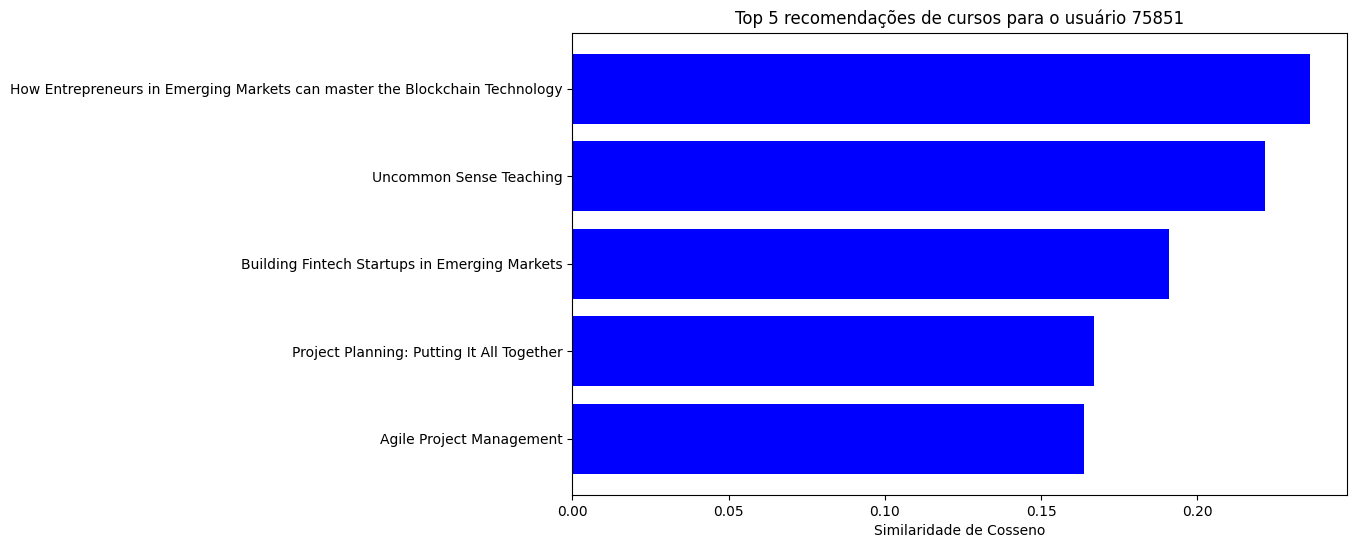

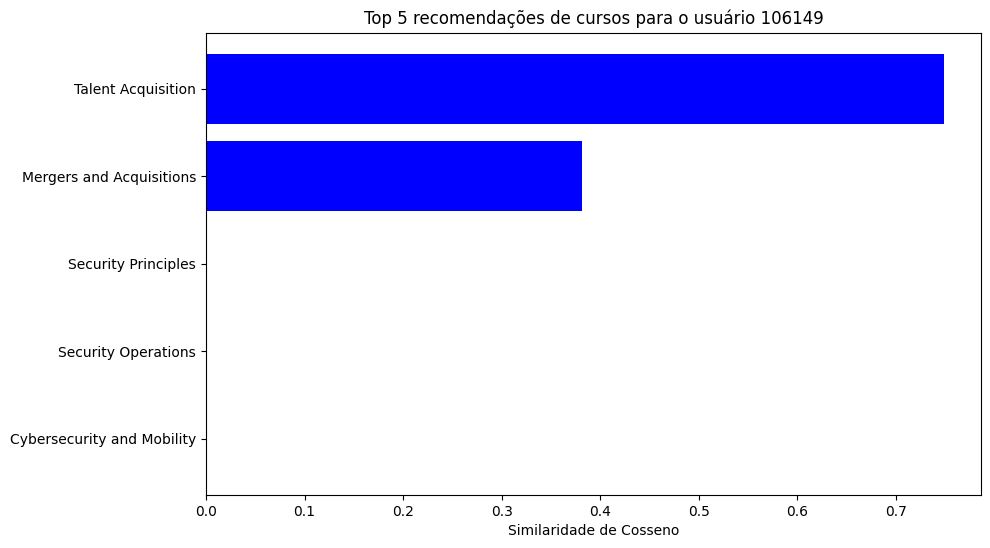

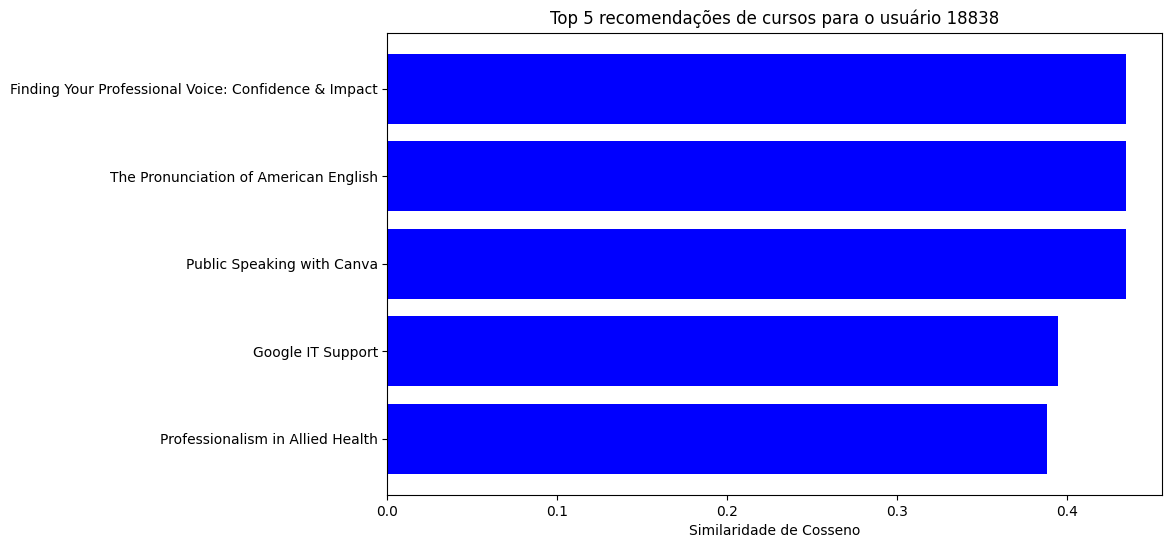

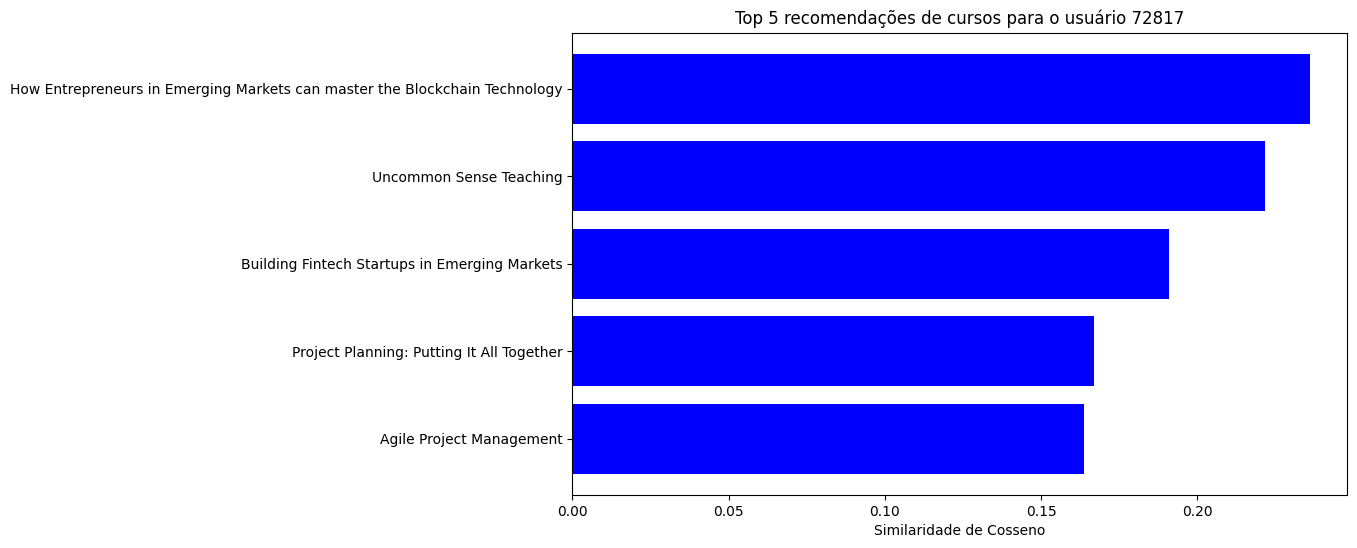

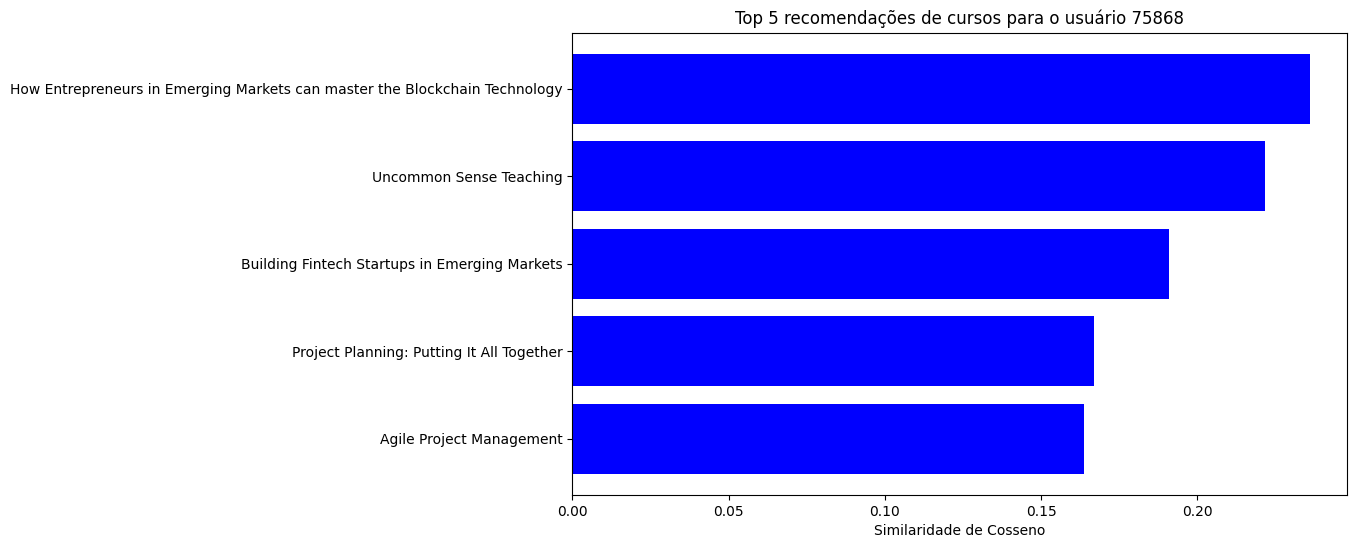

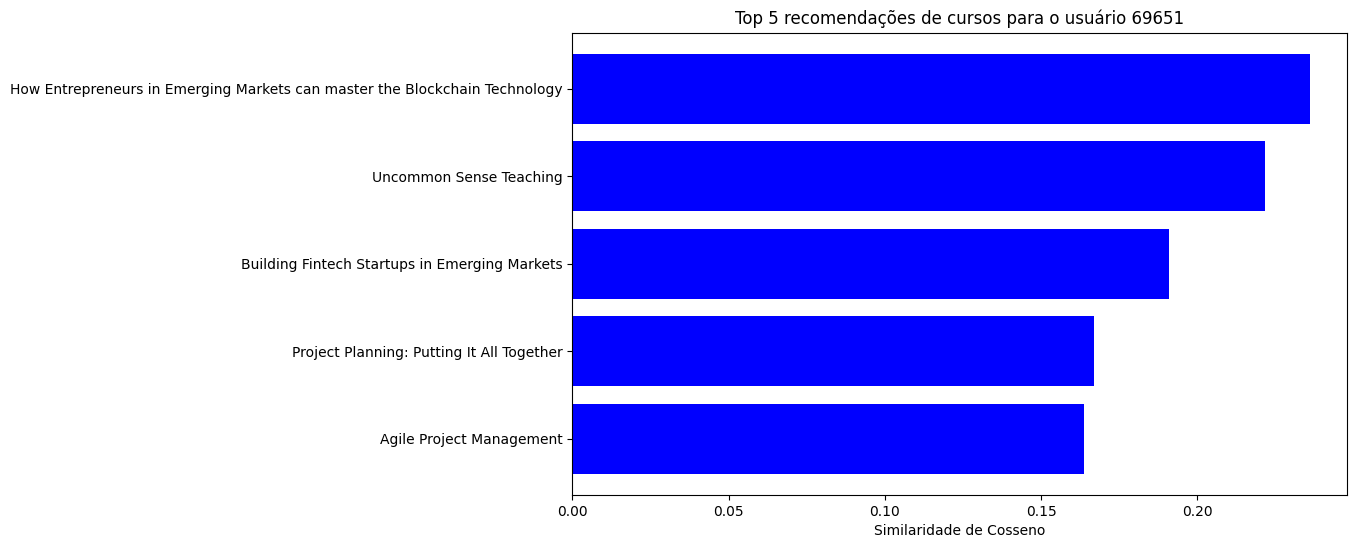

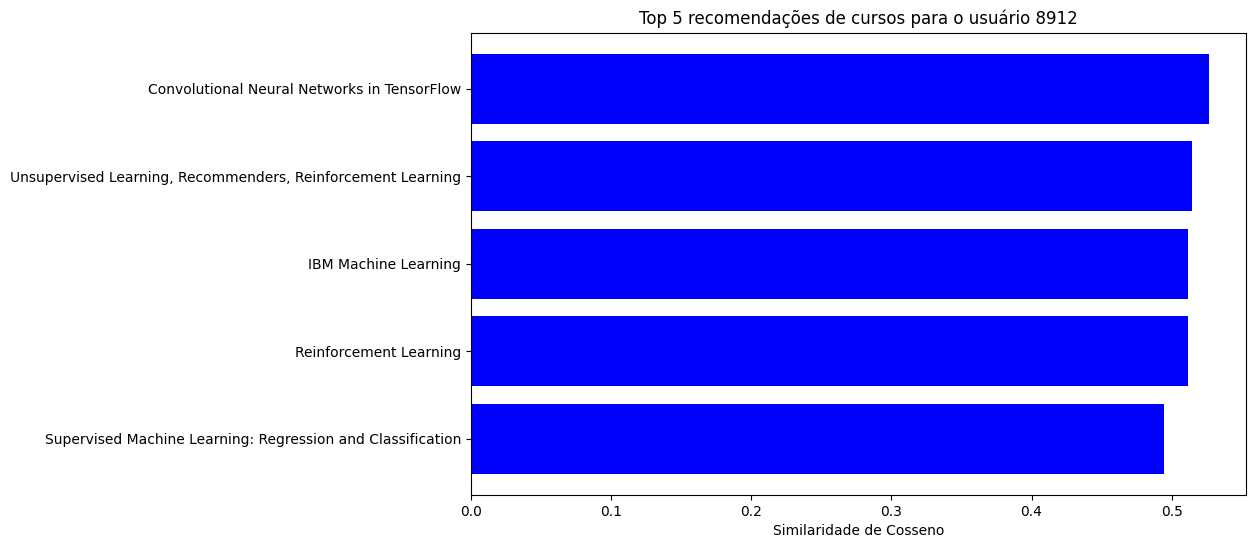

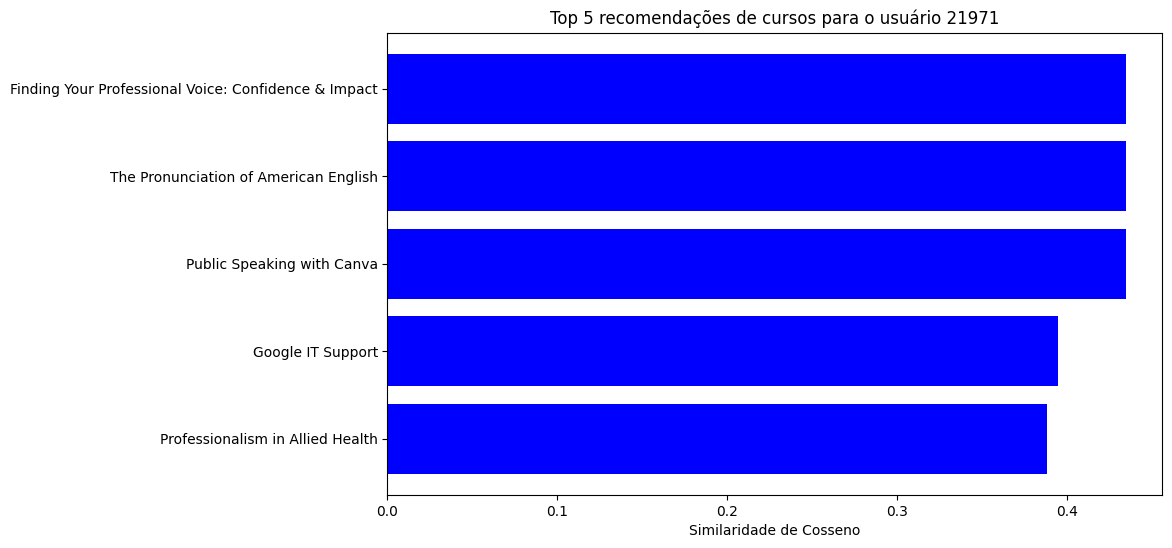

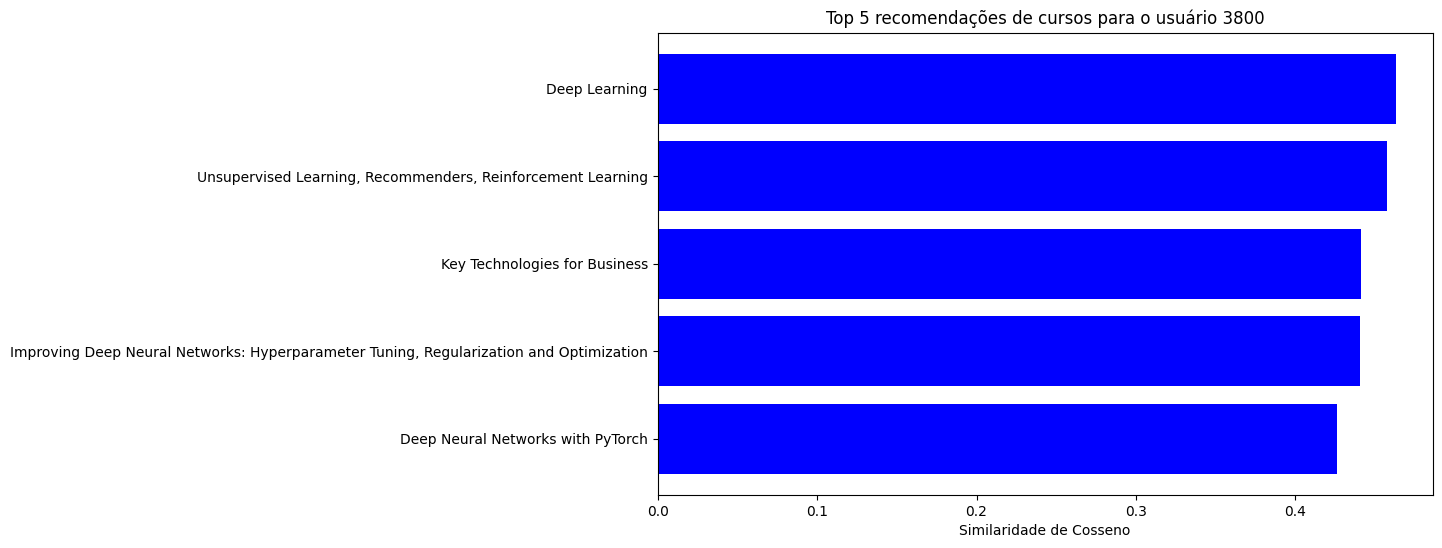

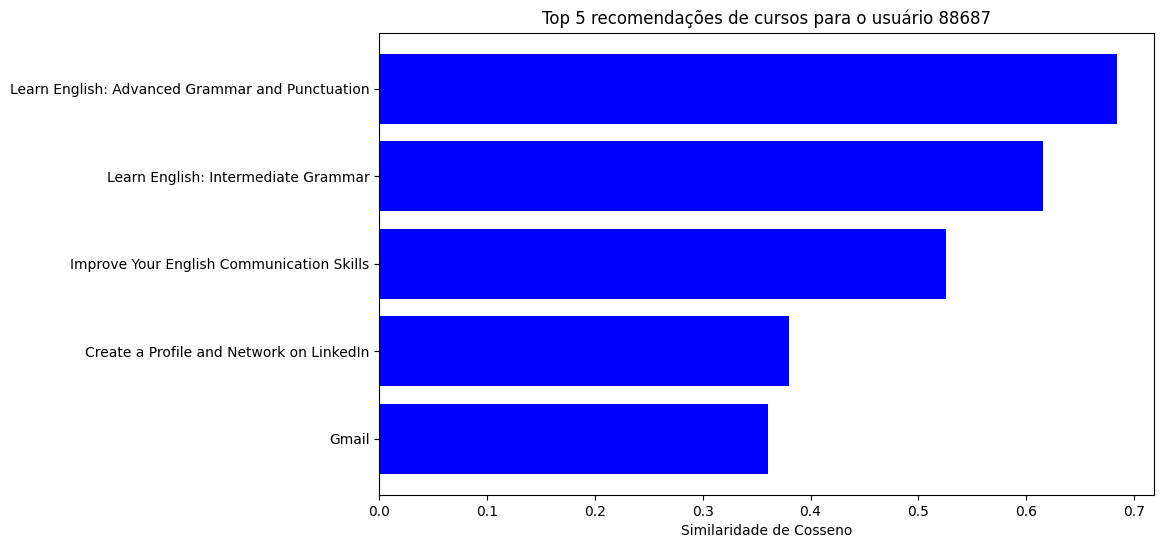

In [20]:
N = 5  
for user_index in random_users:
    reviewed_courses = set(pivot_df.columns[pivot_df.loc[user_index] > 0])
    
    recommended_courses = []
    similarity_scores = []
    recommended_count = 0
    for course_index in top_indices[user_index]:
        title = course_df.index[course_index]  
        if title not in reviewed_courses:
            similarity_score = similarities[user_index, course_index]  
            recommended_courses.append(title)
            similarity_scores.append(similarity_score)
            recommended_count += 1
            if recommended_count == N:
                break
    
    plt.figure(figsize=(10, 6))
    plt.barh(recommended_courses[::-1], similarity_scores[::-1], color='blue')
    plt.xlabel('Similaridade de Cosseno')
    plt.title(f'Top {N} recomendações de cursos para o usuário {user_index + 1}')

    plt.show()


### Análise dos Resultados Gráficos

A avaliação de desempenho deste sistema baseia-se na capacidade do modelo em sugerir cursos relevantes, utilizando uma abordagem quantitativa e qualitativa.

**Análise Quantitativa:**
Os gráficos acima demonstram a pontuação de similaridade de cosseno para os 5 principais cursos recomendados a 10 usuários aleatórios. Observa-se que as pontuações de similaridade (ex: 1.00, 0.60, 0.75) são significativamente altas para os cursos recomendados. O modelo também filtra com sucesso os cursos que o usuário já avaliou, garantindo que as recomendações sejam de novos conteúdos. Uma pontuação de 1.0 (como em "Programming for Everybody") indica que o curso recomendado compartilha um perfil de habilidades idêntico ou muito próximo ao perfil de interesse agregado do usuário.

**Análise Qualitativa:**
A avaliação qualitativa consiste em verificar manualmente se as habilidades e temas dos cursos sugeridos estão alinhados ao histórico do usuário. Por exemplo, para o **Usuário 66587**, que já fez "HTML, CSS, and Javascript for Web Developers", o sistema recomenda "Information Visualization", "Java Programming" e "Meta React Native". Essas recomendações são pertinentes, pois expandem o conhecimento do usuário em áreas correlatas de desenvolvimento web e de software. Da mesma forma, para o **Usuário 60176**, que fez "What is Data Science?", o sistema sugere "Introduction to Data Science", "AI For Everyone" e "IBM AI Foundations", o que demonstra coerência na trilha de aprendizado.

Essa combinação de análise valida a efetividade do sistema, mesmo na ausência de métricas supervisionadas tradicionais (como RMSE ou Acurácia), que não se aplicam diretamente a este modelo baseado em conteúdo.